# 4 Nodes

## Data Loading

In [116]:
import pandas as pd

# Read data from CSV file
df = pd.read_csv('4-nodes.csv')

# Convert string representations to dictionaries
df['cpu_usage_percentage'] = df['cpu_usage_percentage'].apply(eval)
df['mem_usage_percentage'] = df['mem_usage_percentage'].apply(eval)

# Function to calculate average CPU utilization
def calculate_avg(row):
    values = list(row.values())
    if len(values) != 4: return -1
    return sum(values) / len(values)

# Apply the function to each row
df['avg_cpu_utilization'] = df['cpu_usage_percentage'].apply(calculate_avg)
df['avg_mem_utilization'] = df['mem_usage_percentage'].apply(calculate_avg)

# Drop rows where Prometheus querying is wrong
df = df[df['avg_cpu_utilization'] != -1]
df = df[df['avg_mem_utilization'] != -1]

# Reset index
df.reset_index(drop=True, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             712 non-null    object 
 1   cluster_node_list     712 non-null    object 
 2   cpu_usage_percentage  712 non-null    object 
 3   node_status           712 non-null    object 
 4   cpu_reserve           712 non-null    object 
 5   mem_usage_percentage  712 non-null    object 
 6   mem_reserve           712 non-null    object 
 7   Power                 712 non-null    int64  
 8   Energy                712 non-null    float64
 9   avg_cpu_utilization   712 non-null    float64
 10  avg_mem_utilization   712 non-null    float64
dtypes: float64(3), int64(1), object(7)
memory usage: 61.3+ KB


## Visualization Average CPU / Memory vs POWER

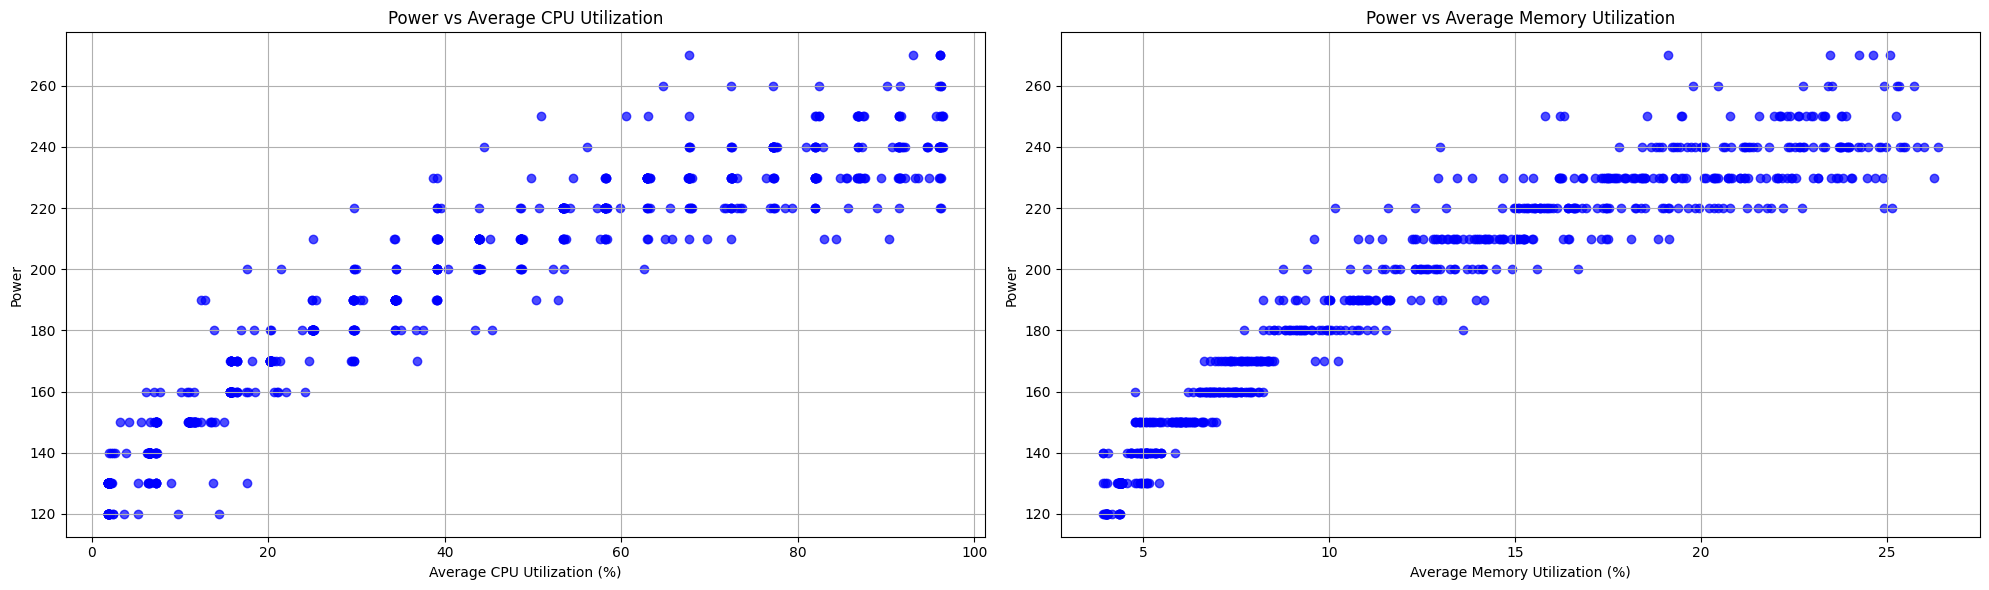

In [11]:
import matplotlib.pyplot as plt
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plot 1: Power vs Average CPU Utilization
axes[0].scatter(df['avg_cpu_utilization'], df['Power'], color='blue', alpha=0.7)
axes[0].set_title('Power vs Average CPU Utilization')
axes[0].set_xlabel('Average CPU Utilization (%)')
axes[0].set_ylabel('Power')
axes[0].grid(True)

# Plot 2: Power vs Average Memory Utilization
axes[1].scatter(df['avg_mem_utilization'], df['Power'], color='blue', alpha=0.7)
axes[1].set_title('Power vs Average Memory Utilization')
axes[1].set_xlabel('Average Memory Utilization (%)')
axes[1].set_ylabel('Power')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Curve Fitting

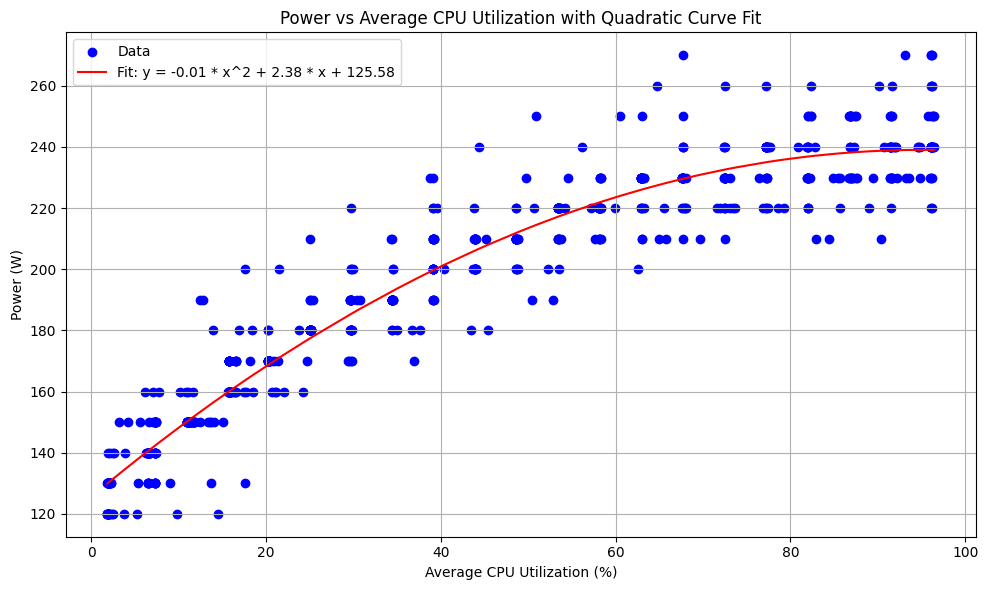

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

# Define the quadratic model function: y = a * x^2 + b * x + c
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

# Extract x and y data
x_data = df['avg_cpu_utilization']
y_data = df['Power']

# Perform curve fitting
popt, pcov = curve_fit(quadratic_model, x_data, y_data)

# Obtain the fitted parameters
a_fit, b_fit, c_fit = popt

# Predicted y values based on the fitted model
y_fit = quadratic_model(x_data, a_fit, b_fit, c_fit)

# Sorting x_data and corresponding y_data
sorted_indices = np.argsort(x_data)
x_sorted = x_data.iloc[sorted_indices]
y_sorted = y_data.iloc[sorted_indices]
y_fit_sorted = y_fit[sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, y_sorted, color='blue', label='Data')
plt.plot(x_sorted, y_fit_sorted, color='red', label=f'Fit: y = {a_fit:.2f} * x^2 + {b_fit:.2f} * x + {c_fit:.2f}')
plt.title('Power vs Average CPU Utilization with Quadratic Curve Fit')
plt.xlabel('Average CPU Utilization (%)')
plt.ylabel('Power (W)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Linear Regression

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Extract individual CPU usage columns
cpu_regression_df = df['cpu_usage_percentage'].apply(pd.Series)

# Rename columns to have a prefix
cpu_regression_df.columns = [f'cpu_usage_{col}' for col in cpu_regression_df.columns]

# Extract individual CPU usage columns
mem_regression_df = df['mem_usage_percentage'].apply(pd.Series)

# Rename columns to have a prefix
mem_regression_df.columns = [f'mem_usage_{col}' for col in mem_regression_df.columns]

regression_df = pd.concat([cpu_regression_df, mem_regression_df, df['Power']], axis=1)
regression_df.head()

,cpu_usage_cillium4,cpu_usage_cillium1,cpu_usage_cillium3,cpu_usage_cillium2,mem_usage_cillium4,mem_usage_cillium1,mem_usage_cillium3,mem_usage_cillium2,Power
0,0.37,5.69,0.73,0.83,3.14,6.43,2.91,3.21,130
1,0.43,7.63,0.77,0.79,3.14,6.54,2.91,3.21,120
2,0.44,7.77,0.69,0.92,3.14,6.51,2.91,3.20,140
3,0.49,7.47,0.82,0.93,3.14,6.42,2.91,3.20,120
4,0.44,6.01,1.05,1.16,3.14,6.38,2.97,3.23,140


In [14]:
X_LR = regression_df.drop('Power', axis=1)  # Features
y_LR = regression_df['Power']               # Target variable

X_train, X_test, y_train, y_test = train_test_split(X_LR, y_LR, test_size=0.2, random_state=0)

In [15]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [16]:
y_pred = model.predict(X_test)

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# R^2 Score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Mean Squared Error: 192.9703905476445
R^2 Score: 0.872156225375693
Coefficients: [ 0.063446   -0.61707303  0.06834755  0.84139767  0.98576942  0.64160177
  0.4687983   1.81616009]
Intercept: 127.29409806000086


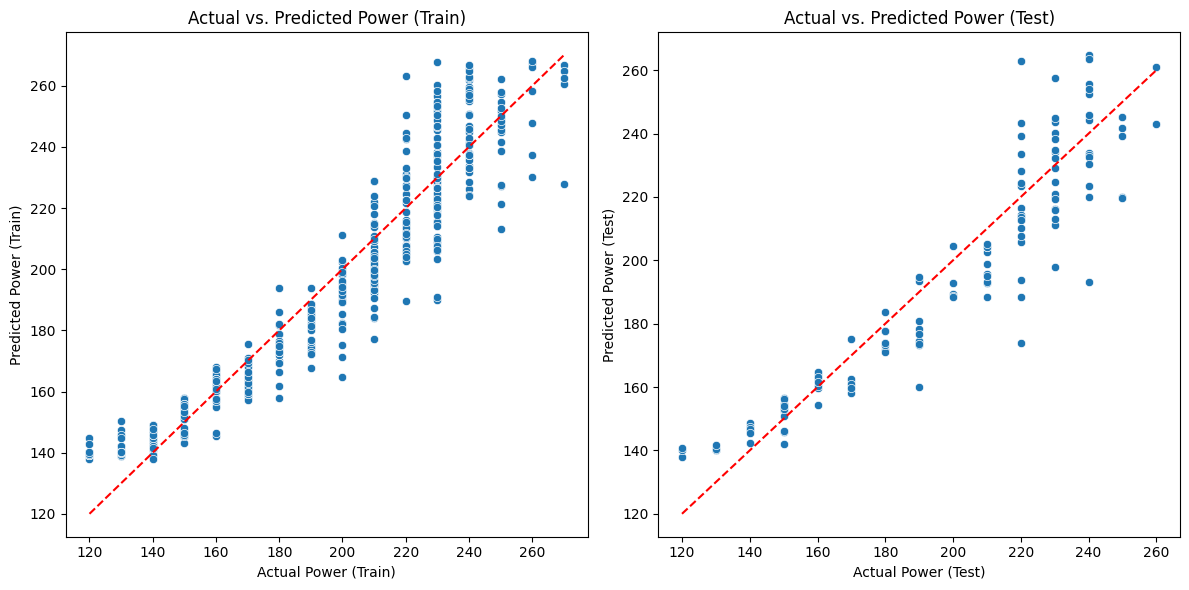

In [18]:
import seaborn as sns
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Plotting
plt.figure(figsize=(12, 6))

# Scatter plot of training data
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
plt.xlabel('Actual Power (Train)')
plt.ylabel('Predicted Power (Train)')
plt.title('Actual vs. Predicted Power (Train)')

# Scatter plot of test data
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Power (Test)')
plt.ylabel('Predicted Power (Test)')
plt.title('Actual vs. Predicted Power (Test)')

plt.tight_layout()
plt.show()

## Neural Network

In [117]:
# Extract individual CPU usage columns
cpu_regression_df = df['cpu_usage_percentage'].apply(pd.Series)

# Rename columns to have a prefix
cpu_regression_df.columns = [f'cpu_usage_{col}' for col in cpu_regression_df.columns]

# Extract individual CPU usage columns
mem_regression_df = df['mem_usage_percentage'].apply(pd.Series)

# Rename columns to have a prefix
mem_regression_df.columns = [f'mem_usage_{col}' for col in mem_regression_df.columns]

regression_df = pd.concat([cpu_regression_df, mem_regression_df, df['Power']], axis=1)
regression_df.head()

,cpu_usage_cillium4,cpu_usage_cillium1,cpu_usage_cillium3,cpu_usage_cillium2,mem_usage_cillium4,mem_usage_cillium1,mem_usage_cillium3,mem_usage_cillium2,Power
0,0.37,5.69,0.73,0.83,3.14,6.43,2.91,3.21,130
1,0.43,7.63,0.77,0.79,3.14,6.54,2.91,3.21,120
2,0.44,7.77,0.69,0.92,3.14,6.51,2.91,3.20,140
3,0.49,7.47,0.82,0.93,3.14,6.42,2.91,3.20,120
4,0.44,6.01,1.05,1.16,3.14,6.38,2.97,3.23,140


In [120]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Prepare the data
X = regression_df.drop('Power', axis=1)  # Features
y = regression_df['Power']               # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, shuffle=True)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer with a single node
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=2, verbose=1, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100


c:\Users\Patchapong\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 35148.3711 - val_loss: 7712.6812
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6965.2188 - val_loss: 5213.1909
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5643.9985 - val_loss: 3879.9873
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3881.7559 - val_loss: 2063.5205
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1813.6013 - val_loss: 685.7147
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 560.7632 - val_loss: 247.2887
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 264.7851 - val_loss: 117.3868
Epoch 8/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150.4259 - val_loss: 81.7682
Epoch 9/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 116.1628 - val_loss: 76.0830
Epoch 10/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 109.8539 - val_loss: 71.7441
Epoch 11/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111.3918 - val_loss: 77.5782
Epo

In [121]:
# Make predictions
y_train_pred = model.predict(X_train).flatten()  # Flatten to make it 1D
y_test_pred = model.predict(X_test).flatten()    # Flatten to make it 1D

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Training Mean Squared Error: {mse_train}")
print(f"Test Mean Squared Error: {mse_test}")
print(f"Training R^2 Score: {r2_train}")
print(f"Test R^2 Score: {r2_test}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Training Mean Squared Error: 81.01127976493004
Test Mean Squared Error: 64.9048219005149
Training R^2 Score: 0.9486373066902161
Test R^2 Score: 0.9637146592140198


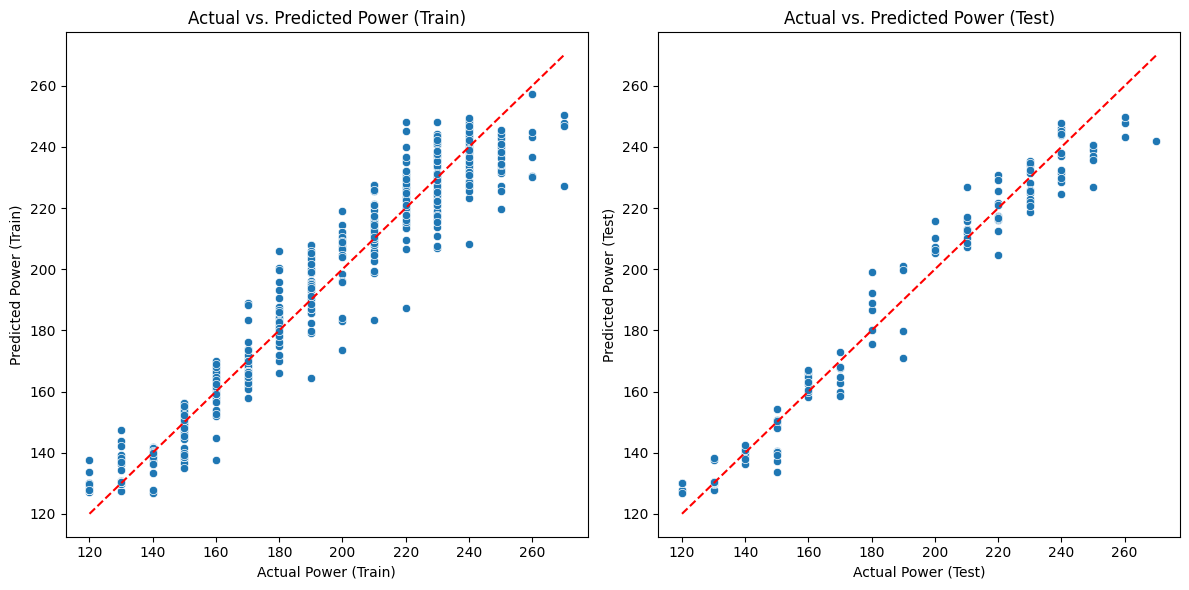

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(12, 6))

# Scatter plot of training data
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
plt.xlabel('Actual Power (Train)')
plt.ylabel('Predicted Power (Train)')
plt.title('Actual vs. Predicted Power (Train)')

# Scatter plot of test data
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Power (Test)')
plt.ylabel('Predicted Power (Test)')
plt.title('Actual vs. Predicted Power (Test)')

plt.tight_layout()
plt.show()


In [126]:
# Save the model
model.save('power_4node.keras')

import joblib

# Save the scaler
joblib.dump(scaler, 'scaler_4node.pkl')

['scaler_4node.pkl']

# 3 Nodes

## Data Loading

In [211]:
import pandas as pd

# Read data from CSV file
df1 = pd.read_csv('3-nodes-1.csv')
df2 = pd.read_csv('3-nodes-2.csv')
df3 = pd.read_csv('3-nodes-3.csv')
df  = pd.concat([df1, df2, df3])

# Convert string representations to dictionaries
df['cpu_usage_percentage'] = df['cpu_usage_percentage'].apply(eval)
df['mem_usage_percentage'] = df['mem_usage_percentage'].apply(eval)

# Function to calculate average CPU utilization
def calculate_avg(row):
    values = list(row.values())
    if len(values) != 3: return -1
    return sum(values) / len(values)

# Apply the function to each row
df['avg_cpu_utilization'] = df['cpu_usage_percentage'].apply(calculate_avg)
df['avg_mem_utilization'] = df['mem_usage_percentage'].apply(calculate_avg)

# Drop rows where Prometheus querying is wrong
df = df[df['avg_cpu_utilization'] != -1]
df = df[df['avg_mem_utilization'] != -1]

# Reset index
df.reset_index(drop=True, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795 entries, 0 to 794
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             795 non-null    object 
 1   cluster_node_list     795 non-null    object 
 2   cpu_usage_percentage  795 non-null    object 
 3   node_status           795 non-null    object 
 4   cpu_reserve           795 non-null    object 
 5   mem_usage_percentage  795 non-null    object 
 6   mem_reserve           795 non-null    object 
 7   Power                 795 non-null    int64  
 8   Energy                795 non-null    float64
 9   avg_cpu_utilization   795 non-null    float64
 10  avg_mem_utilization   795 non-null    float64
dtypes: float64(3), int64(1), object(7)
memory usage: 68.4+ KB


## Data Visualization

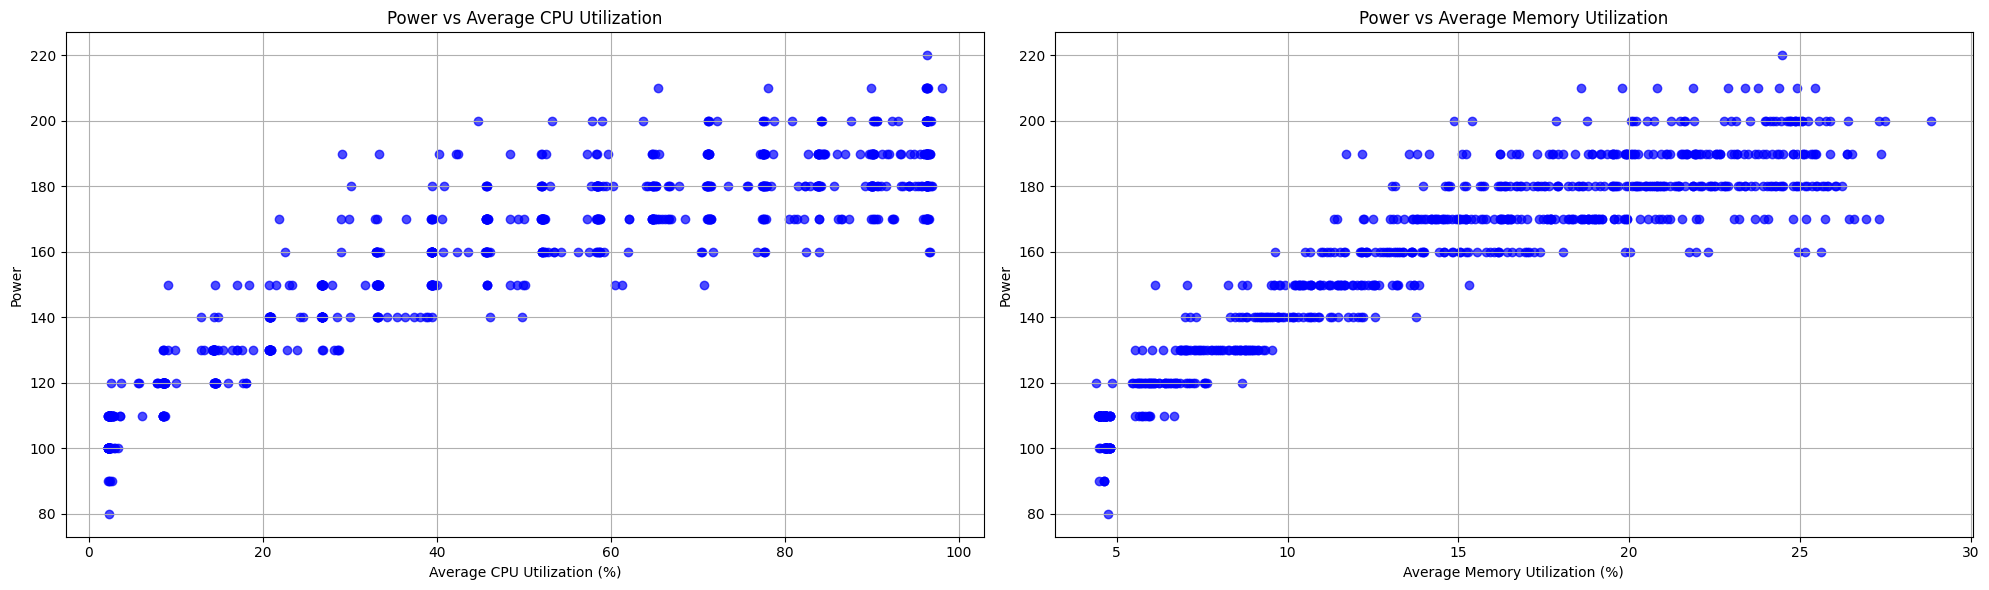

In [212]:
import matplotlib.pyplot as plt
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plot 1: Power vs Average CPU Utilization
axes[0].scatter(df['avg_cpu_utilization'], df['Power'], color='blue', alpha=0.7)
axes[0].set_title('Power vs Average CPU Utilization')
axes[0].set_xlabel('Average CPU Utilization (%)')
axes[0].set_ylabel('Power')
axes[0].grid(True)

# Plot 2: Power vs Average Memory Utilization
axes[1].scatter(df['avg_mem_utilization'], df['Power'], color='blue', alpha=0.7)
axes[1].set_title('Power vs Average Memory Utilization')
axes[1].set_xlabel('Average Memory Utilization (%)')
axes[1].set_ylabel('Power')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Curve Fitting

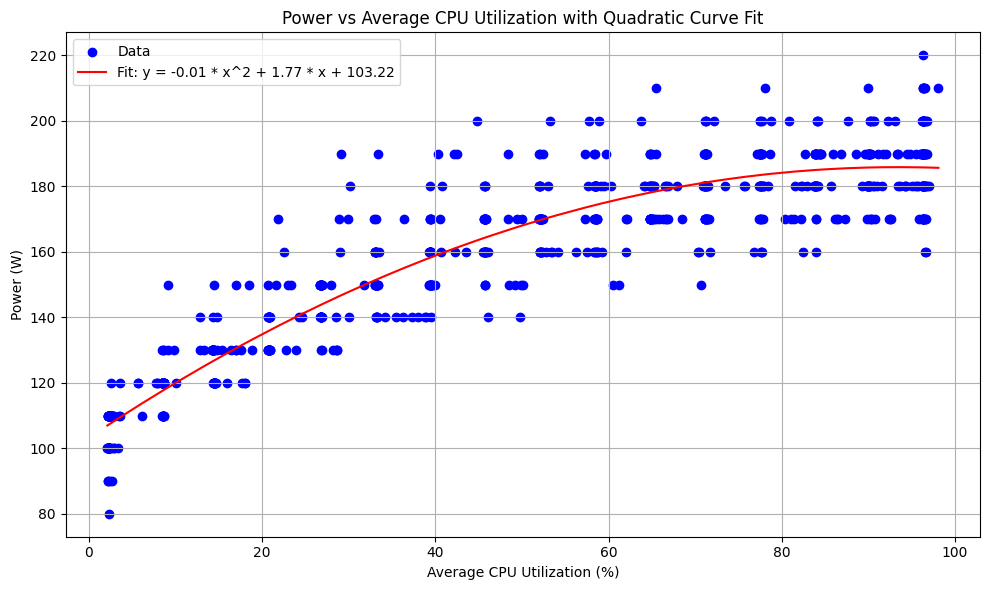

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

# Define the quadratic model function: y = a * x^2 + b * x + c
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

# Extract x and y data
x_data = df['avg_cpu_utilization']
y_data = df['Power']

# Perform curve fitting
popt, pcov = curve_fit(quadratic_model, x_data, y_data)

# Obtain the fitted parameters
a_fit, b_fit, c_fit = popt

# Predicted y values based on the fitted model
y_fit = quadratic_model(x_data, a_fit, b_fit, c_fit)

# Sorting x_data and corresponding y_data
sorted_indices = np.argsort(x_data)
x_sorted = x_data.iloc[sorted_indices]
y_sorted = y_data.iloc[sorted_indices]
y_fit_sorted = y_fit[sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, y_sorted, color='blue', label='Data')
plt.plot(x_sorted, y_fit_sorted, color='red', label=f'Fit: y = {a_fit:.2f} * x^2 + {b_fit:.2f} * x + {c_fit:.2f}')
plt.title('Power vs Average CPU Utilization with Quadratic Curve Fit')
plt.xlabel('Average CPU Utilization (%)')
plt.ylabel('Power (W)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Neural Network

In [214]:
# Extract individual CPU usage columns
cpu_regression_df = df['cpu_usage_percentage'].apply(pd.Series)

# Rename columns to have a prefix
cpu_regression_df.columns = [f'cpu_usage_{col}' for col in cpu_regression_df.columns]

# Extract individual CPU usage columns
mem_regression_df = df['mem_usage_percentage'].apply(pd.Series)

# Rename columns to have a prefix
mem_regression_df.columns = [f'mem_usage_{col}' for col in mem_regression_df.columns]

regression_df = pd.concat([cpu_regression_df, mem_regression_df, df['Power']], axis=1)

# Replace NaN values with 0
regression_df.fillna(0, inplace=True)

regression_df.head()

,cpu_usage_cillium4,cpu_usage_cillium1,cpu_usage_cillium3,cpu_usage_cillium2,mem_usage_cillium4,mem_usage_cillium1,mem_usage_cillium3,mem_usage_cillium2,Power
0,0.40,5.62,0.69,0.0,3.28,7.91,2.99,0.0,100
1,0.36,5.58,0.59,0.0,3.28,7.94,2.99,0.0,100
2,0.38,5.44,0.72,0.0,3.28,7.83,2.99,0.0,100
3,0.41,5.71,0.79,0.0,3.26,7.88,2.99,0.0,100
4,0.43,5.74,0.68,0.0,3.25,7.86,2.99,0.0,100


In [215]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Prepare the data
X = regression_df.drop('Power', axis=1)  # Features
y = regression_df['Power']               # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, shuffle=True)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer with a single node
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=3, verbose=1, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100


c:\Users\Patchapong\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 24359.5371 - val_loss: 18872.8789
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12768.3604 - val_loss: 2611.3425
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2270.1812 - val_loss: 1488.3899
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1369.1385 - val_loss: 982.8647
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 891.5169 - val_loss: 689.7753
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 647.8789 - val_loss: 502.3268
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 481.5118 - val_loss: 394.6615
Epoch 8/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 409.8105 - val_loss: 308.6465
Epoch 9/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 301.3916 - val_loss: 268.3649
Epoch 10/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 275.6832 - val_loss: 229.8896
Epoch 11/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 221.5273 - val_loss: 215.9857

In [216]:
# Make predictions
y_train_pred = model.predict(X_train).flatten()  # Flatten to make it 1D
y_test_pred = model.predict(X_test).flatten()    # Flatten to make it 1D

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Training Mean Squared Error: {mse_train}")
print(f"Test Mean Squared Error: {mse_test}")
print(f"Training R^2 Score: {r2_train}")
print(f"Test R^2 Score: {r2_test}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Training Mean Squared Error: 97.52890089306096
Test Mean Squared Error: 69.81318262713681
Training R^2 Score: 0.892574667930603
Test R^2 Score: 0.9175866842269897


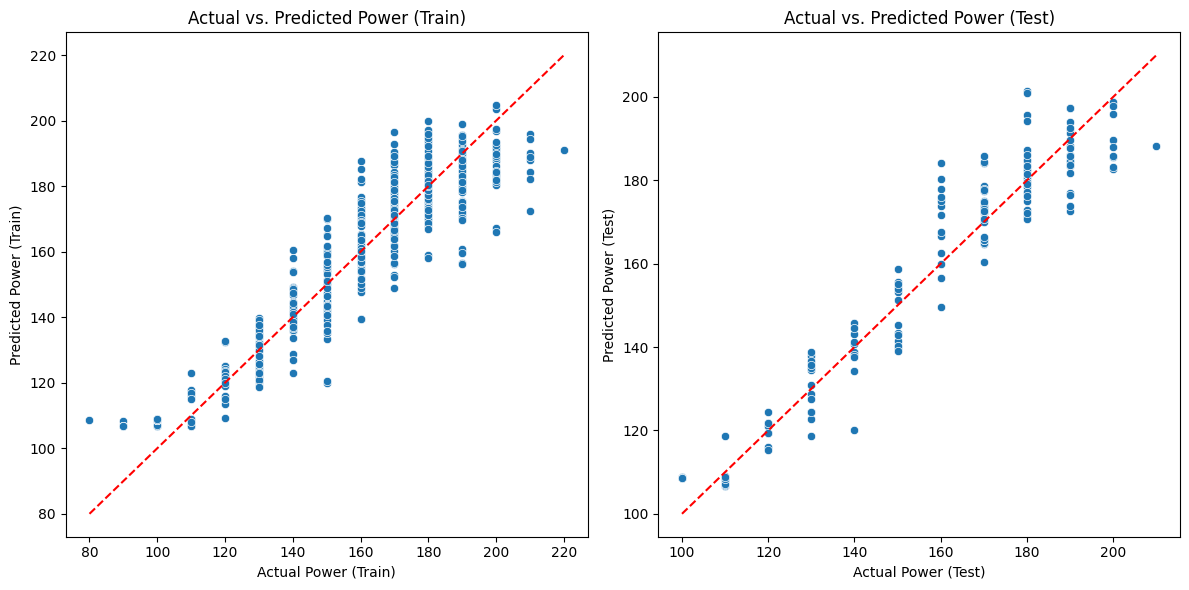

In [217]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(12, 6))

# Scatter plot of training data
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
plt.xlabel('Actual Power (Train)')
plt.ylabel('Predicted Power (Train)')
plt.title('Actual vs. Predicted Power (Train)')

# Scatter plot of test data
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Power (Test)')
plt.ylabel('Predicted Power (Test)')
plt.title('Actual vs. Predicted Power (Test)')

plt.tight_layout()
plt.show()

# 2 Nodes

## Data Loading

In [153]:
import pandas as pd

# Read data from CSV file
df = pd.read_csv('2-nodes-1.csv')

# Convert string representations to dictionaries
df['cpu_usage_percentage'] = df['cpu_usage_percentage'].apply(eval)
df['mem_usage_percentage'] = df['mem_usage_percentage'].apply(eval)

# Function to calculate average CPU utilization
def calculate_avg(row):
    values = list(row.values())
    if len(values) != 2: return -1
    return sum(values) / len(values)

# Apply the function to each row
df['avg_cpu_utilization'] = df['cpu_usage_percentage'].apply(calculate_avg)
df['avg_mem_utilization'] = df['mem_usage_percentage'].apply(calculate_avg)

# Drop rows where Prometheus querying is wrong
df = df[df['avg_cpu_utilization'] != -1]
df = df[df['avg_mem_utilization'] != -1]

# Reset index
df.reset_index(drop=True, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             211 non-null    object 
 1   cluster_node_list     211 non-null    object 
 2   cpu_usage_percentage  211 non-null    object 
 3   node_status           211 non-null    object 
 4   cpu_reserve           211 non-null    object 
 5   mem_usage_percentage  211 non-null    object 
 6   mem_reserve           211 non-null    object 
 7   Power                 211 non-null    int64  
 8   Energy                211 non-null    float64
 9   avg_cpu_utilization   211 non-null    float64
 10  avg_mem_utilization   211 non-null    float64
dtypes: float64(3), int64(1), object(7)
memory usage: 18.3+ KB


## Data Visualization

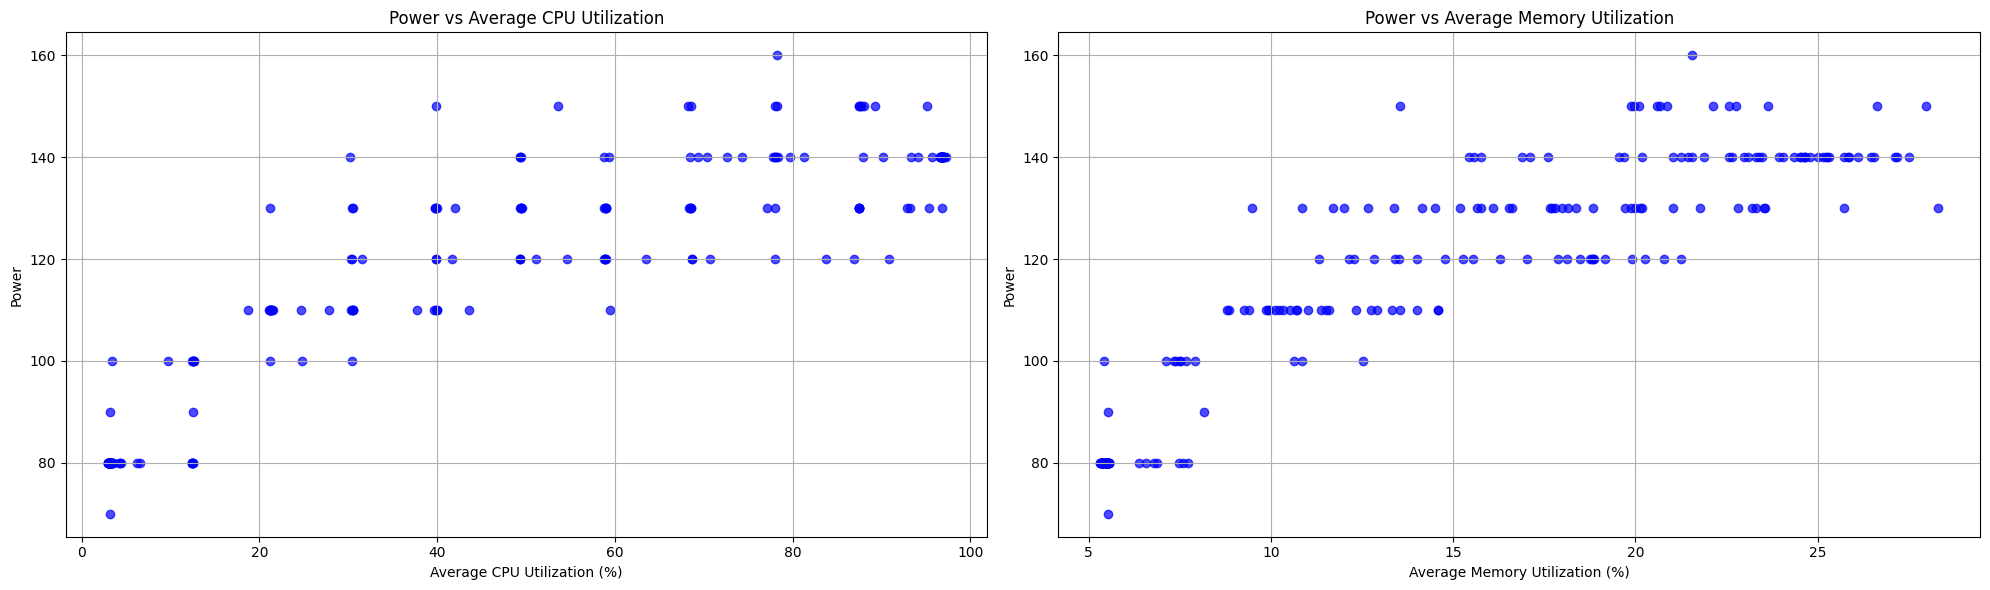

In [154]:
import matplotlib.pyplot as plt
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plot 1: Power vs Average CPU Utilization
axes[0].scatter(df['avg_cpu_utilization'], df['Power'], color='blue', alpha=0.7)
axes[0].set_title('Power vs Average CPU Utilization')
axes[0].set_xlabel('Average CPU Utilization (%)')
axes[0].set_ylabel('Power')
axes[0].grid(True)

# Plot 2: Power vs Average Memory Utilization
axes[1].scatter(df['avg_mem_utilization'], df['Power'], color='blue', alpha=0.7)
axes[1].set_title('Power vs Average Memory Utilization')
axes[1].set_xlabel('Average Memory Utilization (%)')
axes[1].set_ylabel('Power')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Curve Fitting

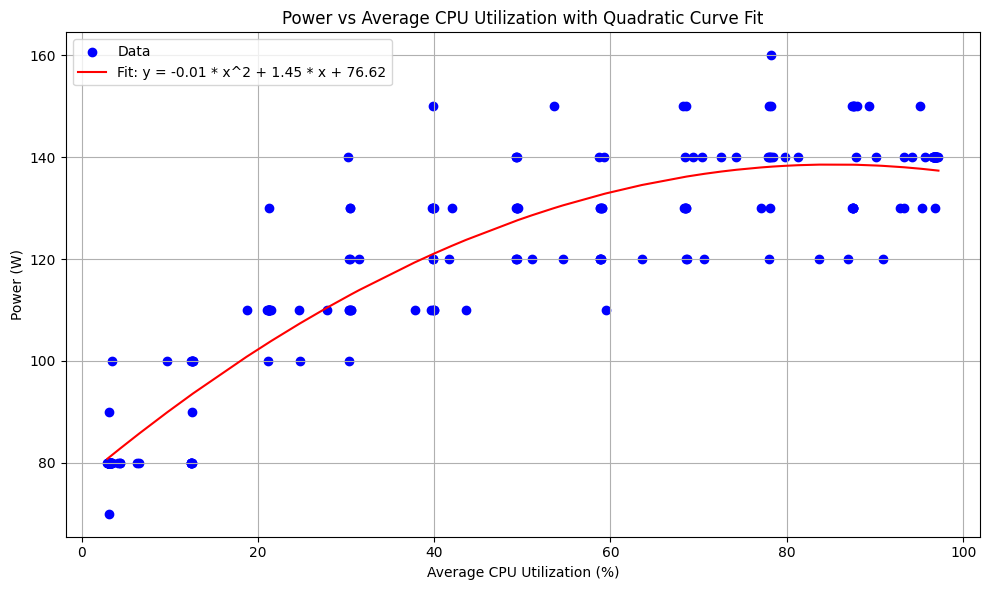

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

# Define the quadratic model function: y = a * x^2 + b * x + c
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

# Extract x and y data
x_data = df['avg_cpu_utilization']
y_data = df['Power']

# Perform curve fitting
popt, pcov = curve_fit(quadratic_model, x_data, y_data)

# Obtain the fitted parameters
a_fit, b_fit, c_fit = popt

# Predicted y values based on the fitted model
y_fit = quadratic_model(x_data, a_fit, b_fit, c_fit)

# Sorting x_data and corresponding y_data
sorted_indices = np.argsort(x_data)
x_sorted = x_data.iloc[sorted_indices]
y_sorted = y_data.iloc[sorted_indices]
y_fit_sorted = y_fit[sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, y_sorted, color='blue', label='Data')
plt.plot(x_sorted, y_fit_sorted, color='red', label=f'Fit: y = {a_fit:.2f} * x^2 + {b_fit:.2f} * x + {c_fit:.2f}')
plt.title('Power vs Average CPU Utilization with Quadratic Curve Fit')
plt.xlabel('Average CPU Utilization (%)')
plt.ylabel('Power (W)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Neural Network

In [156]:
# Extract individual CPU usage columns
cpu_regression_df = df['cpu_usage_percentage'].apply(pd.Series)

# Rename columns to have a prefix
cpu_regression_df.columns = [f'cpu_usage_{col}' for col in cpu_regression_df.columns]

# Extract individual CPU usage columns
mem_regression_df = df['mem_usage_percentage'].apply(pd.Series)

# Rename columns to have a prefix
mem_regression_df.columns = [f'mem_usage_{col}' for col in mem_regression_df.columns]

regression_df = pd.concat([cpu_regression_df, mem_regression_df, df['Power']], axis=1)

# Replace NaN values with 0
regression_df.fillna(0, inplace=True)

regression_df.head()

,cpu_usage_cillium1,cpu_usage_cillium3,mem_usage_cillium1,mem_usage_cillium3,Power
0,5.76,0.70,7.97,2.99,80
1,5.91,0.76,7.97,2.99,80
2,5.42,0.78,7.89,2.98,80
3,5.22,0.77,7.88,2.99,80
4,5.41,0.71,7.89,2.98,80


In [178]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Prepare the data
X = regression_df.drop('Power', axis=1)  # Features
y = regression_df['Power']               # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, shuffle=True)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer with a single node
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100


c:\Users\Patchapong\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 12131.1650 - val_loss: 9864.1777
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5504.6475 - val_loss: 1794.4619
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1662.1929 - val_loss: 1469.8008
Epoch 4/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1237.6466 - val_loss: 698.8860
Epoch 5/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 692.4823 - val_loss: 412.1148
Epoch 6/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 396.5961 - val_loss: 214.6302
Epoch 7/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 235.3104 - val_loss: 165.8499
Epoch 8/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 139.7855 - val_loss: 133.4854
Epoch 9/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152.5151 - val_loss: 107.9044
Epoch 10/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113.9967 - val_loss: 101.1294
Epoch 11/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112.2802 - val_loss: 82.8033
Ep

In [179]:
# Make predictions
y_train_pred = model.predict(X_train).flatten()  # Flatten to make it 1D
y_test_pred = model.predict(X_test).flatten()    # Flatten to make it 1D

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Training Mean Squared Error: {mse_train}")
print(f"Test Mean Squared Error: {mse_test}")
print(f"Training R^2 Score: {r2_train}")
print(f"Test R^2 Score: {r2_test}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training Mean Squared Error: 63.71129209571553
Test Mean Squared Error: 95.32174591584737
Training R^2 Score: 0.8900265097618103
Test R^2 Score: 0.8644022941589355


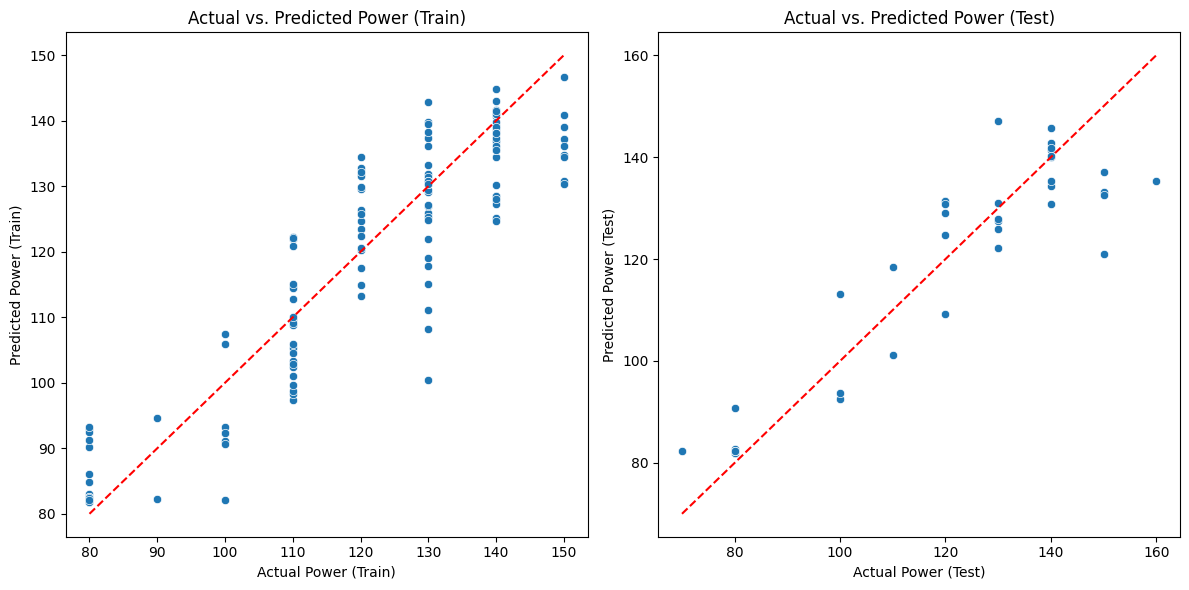

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(12, 6))

# Scatter plot of training data
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
plt.xlabel('Actual Power (Train)')
plt.ylabel('Predicted Power (Train)')
plt.title('Actual vs. Predicted Power (Train)')

# Scatter plot of test data
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Power (Test)')
plt.ylabel('Predicted Power (Test)')
plt.title('Actual vs. Predicted Power (Test)')

plt.tight_layout()
plt.show()